In [53]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

# Prepare Dataset

Import the preprocessed data set, which was preprocessed in the `data_preparation.ipynb` notebook

In [2]:
df_boston = pd.read_csv('./data/prepared/rides_data_prepared.csv', dtype={'start_station_id': np.int64, 'end_station_id': 'string', 'end_station_name': 'string', 'start_station_name': 'string', 'bike_id': np.int64, 'user_type': 'string'})
df_boston['start_time'] = pd.to_datetime(df_boston['start_time'], format='%Y-%m-%d %X')

df_boston.head()

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,trip_length,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,date_time
0,2015-01-01 00:21:44,2015-01-01 00:30:47,115,96,Porter Square Station,Cambridge Main Library at Broadway / Trowbridg...,277,Subscriber,543.0,42.387995,-71.119084,42.373379,-71.111075,2015-01-01 00:00:00
1,2015-01-01 00:27:03,2015-01-01 00:34:21,80,95,MIT Stata Center at Vassar St / Main St,Cambridge St - at Columbia St / Webster Ave,648,Subscriber,438.0,42.361962,-71.092053,42.372969,-71.094445,2015-01-01 00:00:00
2,2015-01-01 00:31:31,2015-01-01 00:35:46,91,68,One Kendall Square at Hampshire St / Portland St,Central Square at Mass Ave / Essex St,555,Subscriber,255.0,42.366277,-71.091690,42.365070,-71.103100,2015-01-01 01:00:00
3,2015-01-01 00:53:46,2015-01-01 01:00:58,115,96,Porter Square Station,Cambridge Main Library at Broadway / Trowbridg...,1307,Subscriber,432.0,42.387995,-71.119084,42.373379,-71.111075,2015-01-01 01:00:00
4,2015-01-01 01:07:06,2015-01-01 01:19:21,105,88,Lower Cambridgeport at Magazine St/Riverside Rd,Inman Square at Vellucci Plaza / Hampshire St,177,Customer,735.0,42.356954,-71.113687,42.374035,-71.101427,2015-01-01 01:00:00


## Prepare Data set
### Calculate Demand per Hour

First of all, it is necessary to transform the data set such that we obtain a time series with hourly frequency providing the demand for bike rentals. We define demand as the number of bike rentals that started in a given hour. 

In [3]:
df_demand = df_boston.resample(rule='H', on='start_time').size().reset_index(name='demand')
df_demand.columns = ['date_time', 'demand']
df_demand.head()


,date_time,demand
0,2015-01-01 00:00:00,4
1,2015-01-01 01:00:00,3
2,2015-01-01 02:00:00,1
3,2015-01-01 03:00:00,0
4,2015-01-01 04:00:00,1


### Include Weather Data
Next, the weather data is included into the dataset. For this we just need to merge the two datasets, as both are already in hourly frequency. 

In [4]:
df_weather = pd.read_csv('./data/weather_hourly_boston.csv')
df_weather['date_time'] = pd.to_datetime(df_weather['date_time'], format='%Y-%m-%d %X')
df_demand = df_demand.merge(df_weather, how = 'left', on = 'date_time')
df_demand.head()

,date_time,demand,max_temp,min_temp,precip
0,2015-01-01 00:00:00,4,NaN,NaN,NaN
1,2015-01-01 01:00:00,3,NaN,NaN,NaN
2,2015-01-01 02:00:00,1,NaN,NaN,NaN
3,2015-01-01 03:00:00,0,NaN,NaN,NaN
4,2015-01-01 04:00:00,1,NaN,NaN,NaN


# Feature Engineering

## Previous demand as input

As we have given time series data, it is a common approach to use the demand of previous hours (or days etc.) as an input for the prediction. The assumption we hereby make is that the factors that influence the demand have not changed dramatically within the used time frames. We have decided to construct the following features from previous demand:

* 1 hour: The asssumption is that the demand should not change dramatically between two hours.
* 24 hours: The asssumption is that the current demand should be comparable to the demand exactly one day ago, as factors such as season, time of the day are the same.
* Average demand of the past week at the same day time: This feature is the average of all 7 demand observations of the past week at same time of the day. 

In [5]:
df_demand['demand_h-1'] = df_demand.demand.shift(periods=1)
df_demand['demand_h-24'] = df_demand.demand.shift(periods=24)

df_demand['demand_tmp_h-48'] = df_demand.demand.shift(periods=48)
df_demand['demand_tmp_h-72'] = df_demand.demand.shift(periods=72)
df_demand['demand_tmp_h-96'] = df_demand.demand.shift(periods=96)
df_demand['demand_tmp_h-120'] = df_demand.demand.shift(periods=120)
df_demand['demand_tmp_h-144'] = df_demand.demand.shift(periods=144)
df_demand['demand_tmp_h-168'] = df_demand.demand.shift(periods=144)

df_demand['demand_average_w-1'] = df_demand[['demand_h-24','demand_tmp_h-48','demand_tmp_h-72','demand_tmp_h-96','demand_tmp_h-120','demand_tmp_h-144','demand_tmp_h-168']].mean(axis=1)
df_demand = df_demand.drop(['demand_tmp_h-48','demand_tmp_h-72','demand_tmp_h-96','demand_tmp_h-120','demand_tmp_h-144','demand_tmp_h-168'], axis=1)
df_demand.tail()

,date_time,demand,max_temp,min_temp,precip,demand_h-1,demand_h-24,demand_average_w-1
9226,2015-12-31 19:00:00,26,7.2,7.2,0.0,27.0,7.0,27.285714
9227,2015-12-31 20:00:00,10,7.2,7.2,0.0,26.0,4.0,34.000000
9228,2015-12-31 21:00:00,17,6.1,6.1,0.0,10.0,1.0,34.857143
9229,2015-12-31 22:00:00,18,5.6,5.6,0.0,17.0,2.0,31.857143
9230,2015-12-31 23:00:00,13,5.6,5.6,0.0,18.0,2.0,30.285714


## Average temperature

In [6]:
df_demand['avg_temp'] = (df_demand.min_temp + df_demand.max_temp)/2
df_demand['avg_temp_dev'] = df_demand['avg_temp'] - df_demand['avg_temp'].mean()
df_demand.head()

,date_time,demand,max_temp,min_temp,precip,demand_h-1,demand_h-24,demand_average_w-1,avg_temp,avg_temp_dev
0,2015-01-01 00:00:00,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-01 01:00:00,3,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN
2,2015-01-01 02:00:00,1,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
3,2015-01-01 03:00:00,0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
4,2015-01-01 04:00:00,1,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN


### Temperature change within hour

In [7]:
df_demand['temp_change'] = df_demand.min_temp - df_demand.max_temp

### Season 

In [8]:
def determine_season(row):
    if row.date_time < datetime(2015,3,20):
        return 'winter'
    elif row.date_time >= datetime(2015,3,20) and row.date_time < datetime(2015,6,21):
        return 'spring'
    elif row.date_time >= datetime(2015,6,21) and row.date_time < datetime(2015,9,23):
        return 'autumn's
    else:
        return 'summer'

df_demand['season'] = df_demand.apply((lambda x: determine_season(x)), axis=1)
df_demand = pd.get_dummies(df_demand, columns=['season'])
df_demand.head()

,date_time,demand,max_temp,min_temp,precip,demand_h-1,demand_h-24,demand_average_w-1,avg_temp,avg_temp_dev,temp_change,season_autumn,season_spring,season_winter
0,2015-01-01 00:00:00,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1
1,2015-01-01 01:00:00,3,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,0,0,1
2,2015-01-01 02:00:00,1,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,0,0,1
3,2015-01-01 03:00:00,0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0,0,1
4,2015-01-01 04:00:00,1,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0,0,1


### Time features

In [9]:
# Extract date and time features
df_demand['date'] = df_demand['date_time'].dt.strftime('%Y-%m-%d %X').apply(lambda x: x.split()[0])
df_demand['hour'] = df_demand['date_time'].dt.strftime('%Y-%m-%d %X').apply(lambda x: int(x.split()[1].split(':')[0]))


#### Weekend feature
In the descriptive analysis we have seen that on saturday and sunday the demand particularly low, hence we engineer a feature "weekend" which is 1 for all rides on saturday & sunday and zero for all other days.

In [10]:
def determine_weekend(row):
    if row.date_time.weekday() > 4:
        return 1
    else:
        return 0

df_demand['weekend'] = df_demand.apply((lambda x: determine_weekend(x)), axis=1)
df_demand.head()

,date_time,demand,max_temp,min_temp,precip,demand_h-1,demand_h-24,demand_average_w-1,avg_temp,avg_temp_dev,temp_change,season_autumn,season_spring,season_winter,date,hour,weekend
0,2015-01-01 00:00:00,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,2015-01-01,0,0
1,2015-01-01 01:00:00,3,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,0,0,1,2015-01-01,1,0
2,2015-01-01 02:00:00,1,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,0,0,1,2015-01-01,2,0
3,2015-01-01 03:00:00,0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,0,0,1,2015-01-01,3,0
4,2015-01-01 04:00:00,1,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0,0,1,2015-01-01,4,0


#### Daytime features
Further the descriptive analysis has shown that the daytime, i.e. if it is night, morning, afternoon or evening, plays an important role for the demand. Hence, we engineer four features that respectively indicate if a rides takes place during
* Morning: 6am - 12pm
* Afternoon: 12pm - 6pm
* Evening: 6pm - 11pm
* Night: 12am - 6am

In [11]:
point_of_day = ["morning", "afternoon", "evening", "night"]
morning_hours = [*range(6, 12)]
afternoon_hours = [*range(12, 18)]
evening = [*range(18, 23)]
night = [23] + [*range(0, 6)]


def get_point_of_day(hour):
    if hour in morning_hours:
        return "morning"
    elif hour in afternoon_hours:
        return "afternoon"
    elif hour in evening:
        return "evening"
    elif hour in night:
        return "night"

In [12]:
df_demand['daytime'] = df_demand["date_time"].dt.hour.apply(lambda x: get_point_of_day(x))
df_demand = pd.get_dummies(df_demand, columns=['daytime'])

### Event Feature

There were several public holidays in Boston:
* New Year's Day: Friday, January 1
* Martin Luther King Jr. Day: Monday, January 19
* Presidents' Day: Monday, February 16
* Patriots' Day: Monday, April 20
* Memorial Day: Monday, May 25
* Independence Day: Saturday, July 4
* Labor Day: Monday, September 7
* Columbus Day: Monday, October 12
* Veterans Day: Wednesday, November 11
* Thanksgiving Day: Thursday, November 26
* Christmas Day: Friday, December 25

These events might have influenced the demand

In [13]:
holiday_dates = [datetime(2015,1,1), datetime(2015,1,19), datetime(2015,2,16), datetime(2015,4,20),datetime(2015,5,25), datetime(2015,7,4), datetime(2015,9,7), datetime(2015,10,12), datetime(2015,11,11), datetime(2015,11,26), datetime(2015,12,25)]

df_demand['public_holiday'] = df_demand.apply((lambda x: 1 if x.date_time in holiday_dates else 0), axis=1)

In [14]:
df_demand['temp_hour'] = df_demand.avg_temp * df_demand.hour
df_demand['precip_hour'] = df_demand.precip * df_demand.hour

In [15]:
df_demand['precip_h-1'] = df_demand.precip.shift(periods=1)
df_demand['precip_h-2'] = df_demand.precip.shift(periods=2)

df_demand['precip_l2h'] = df_demand[['precip', 'precip_h-1', 'precip_h-2']].sum(axis=1)
df_demand = df_demand.drop(['precip_h-1', 'precip_h-2'], axis=1)


<AxesSubplot:>

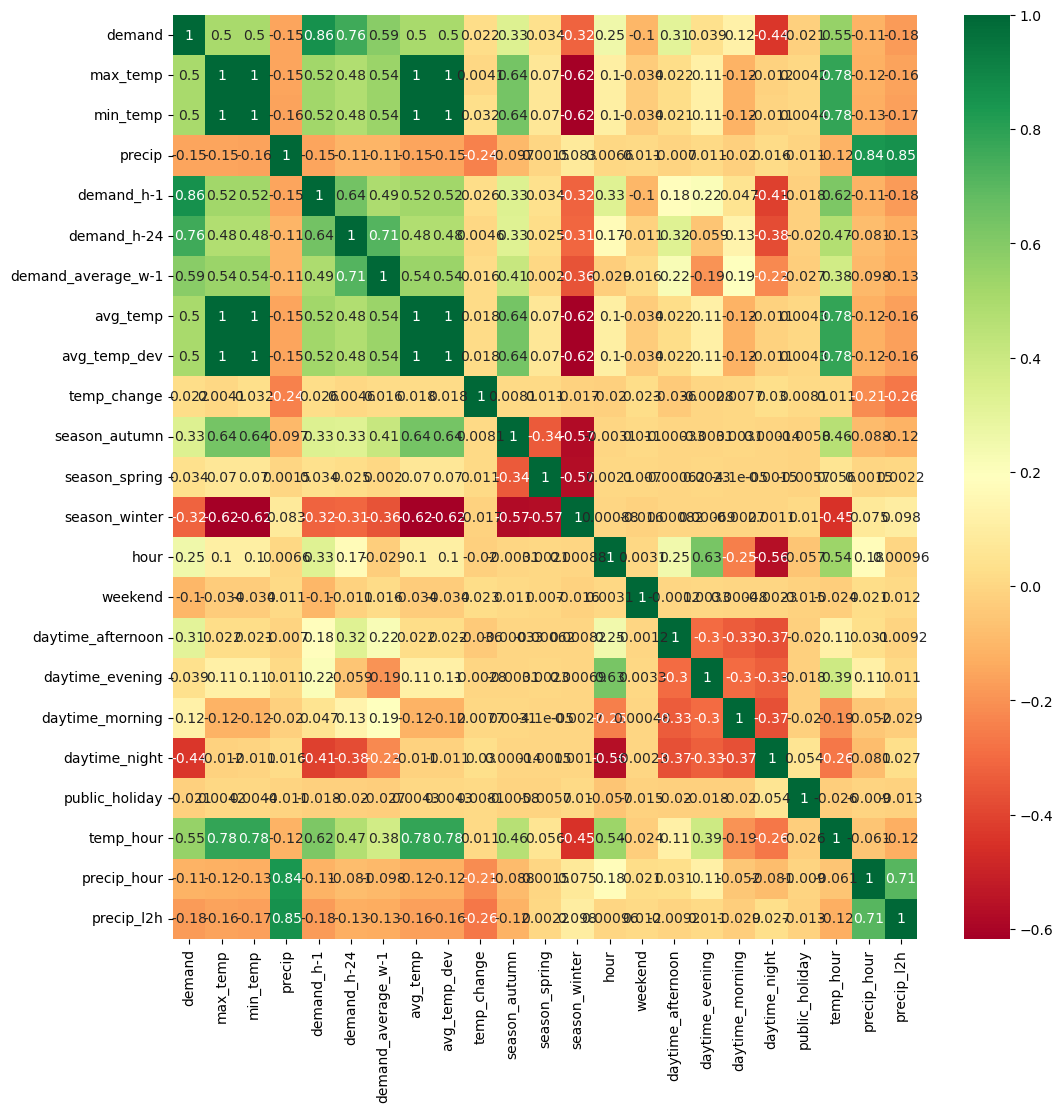

In [16]:
corr_matrix = df_demand.corr()
top_corr_features = corr_matrix.index
plt.figure(figsize=(12,12))

sns.heatmap(df_demand[top_corr_features].corr(),annot=True,cmap="RdYlGn")

## Model building

### Set Up Train and Test set

In [17]:
df_demand = df_demand.dropna()
features = ['max_temp', 'min_temp', 'precip', 'demand_h-1',
       'demand_h-24', 'demand_average_w-1', 'avg_temp', 'avg_temp_dev',
       'temp_change', 'season_autumn', 'season_spring', 'season_winter',
        'hour', 'weekend', 'daytime_afternoon', 'daytime_evening',
       'daytime_morning', 'daytime_night', 'public_holiday', 'temp_hour',
       'precip_hour', 'precip_l2h']
target = 'demand'

X = df_demand[features]
y = df_demand[target]

scaler = StandardScaler()
X_scaled = pd.DataFrame(data=scaler.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_scaled_train, X_scaled_test, y_scaled_train, y_scaled_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

### Function for Hyperparameter Tuning

This function enables us to do hyperparameter tuning for any model in the sklearn universe. We have the choice to either do a RandomizedGridSearch with cross validation or a standard GridSearch, the latter is computationally heavier.

In [46]:
def optimize_hyperparameters(param_grid, model, X, y, randomized=False):
    if randomized:
        grid = RandomizedSearchCV(model, param_grid)
    else: 
        grid = GridSearchCV(model, param_grid)

    grid.fit(X, y)
    print(f"Best params: {grid.best_params_}")
    print(f"Scoring: {grid.best_score_}")
    return grid

### Random Forest

As the first model we pick the Random Forest as it is relatively easy to train and usually performs well on structured data. It is a type of ensemble model, which means that it is made up of multiple decision trees and it makes predictions by averaging the predictions of the individual trees. This can often result in a model that is more accurate and robust than any of the individual trees. Additionally, Random Forest models are resistant to overfitting, which is a common problem when training machine learning models. They are also easy to tune, as they only have a few hyperparameters that need to be set. Overall, Random Forest is a good model to use as a baseline, and it can often be improved upon by using more complex models.

#### Tuning the Hyperparameters
For finding a good set of hyperparameters we choose to do a GridsearchCV for the following hyperparameters:
* **n_estimators**: This is the number of trees in the forest. Increasing the number of trees can often improve the model's performance, but it can also increase the time it takes to train the model.
* **max_depth**: This is the maximum depth of each tree in the forest. Deeper trees can model more complex relationships, but they can also be more prone to overfitting.
* **max_features**: This is the maximum number of features that the model will consider when looking for the best split at each node. A smaller value can reduce the model's complexity and reduce the risk of overfitting, but it can also reduce the model's performance.


In [47]:
TUNE = True

# Hyperparameter tuning
param_grid = {'n_estimators': [50,100,300],
'max_depth': [5, 15, 20, 30],
'max_features': ['sqrt', 'log2', 0.7, 0.8, 0.9 ,1]}
if TUNE:
    grid_search = optimize_hyperparameters(param_grid, RandomForestRegressor(), X_train, y_train, True)
    rf = RandomForestRegressor(**grid_search.best_params_)
else: 
    rf = RandomForestRegressor(**{'n_estimators': 300, 'max_features': 0.8, 'max_depth': 30})

Best params: {'n_estimators': 300, 'max_features': 0.8, 'max_depth': 20}
Scoring: 0.964061744263374


#### Evaluate model performance

For Model Evaluation we will use the RMSE in the following sections, as it is a commonly used metric for regression, easy to interpret and scales the errors to the same units as the target variable.

In [54]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
rf_rmse = mean_squared_error(y_test, y_pred, squared=False)
rf_mae = mean_absolute_error(y_test, y_pred)
print(f'RMSE of Random Forest: {rf_rmse}')
print(f'MAE of Random Forest: {rf_mae}')

RMSE of Random Forest: 30.619844254612413
MAE of Random Forest: 15.778824065698087


If we compare this score with result of a model without any Hyperparameter tuning we can clearly see, that the tuning has a significant impact on the model performance.

In [24]:
baseline_model = RandomForestRegressor()
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)
baseline_rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE of Random Forest: {baseline_rmse}')

RMSE of Random Forest: 31.348323222388096


#### Feature importance

The Feature Importance tells us which features the model deemed most important when making predictions. This can be useful for identifying the most important features for a given prediction task, and for understanding how the model is making predictions.

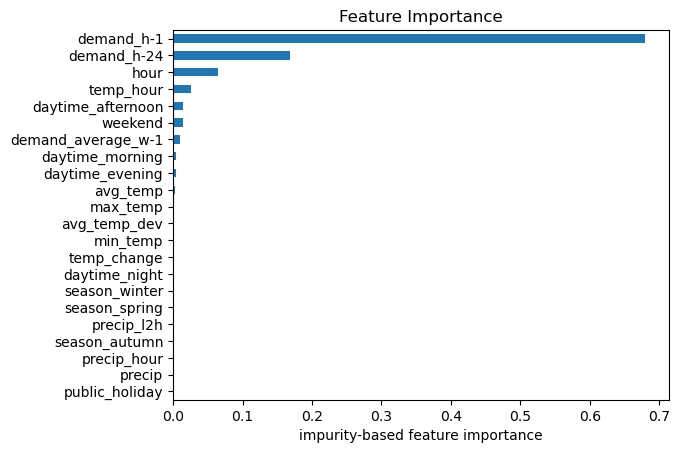

In [25]:
feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.sort_values().plot(kind='barh')
plt.title("Feature Importance")
plt.xlabel("impurity-based feature importance")

plt.show()

Here we can clearly see the model heavily bases its prediction on the demand of the previous hour. This seems very logical, as the descriptive analysis has shown that demand does not change dramatically within two hours. Also our correlation matrix has shown that this feature has the highest correlation with our target variable.

### K-Nearest Neighbor

Our second model KNearestNeighbors (KNN) which is a good regressor to choose because of its simplicity and its ability to adapt to the structure of the data. KNN is a non-parametric method, which means that it does not make any assumptions about the underlying distribution of the data, making it a good choice for data that is complex or has non-linear relationships. Moreover KNN is also easy to interpret as it uses the known output values of the k nearest data points to predict the output for a new data point, making it easy to understand how the model is making predictions.

#### Hyperparameter tuning
We tune the model on the following hyperparameters:

* n_neighbors: The number of nearest neighbors to consider is an important hyperparameter to tune because it determines the number of data points that will be used to make predictions. The larger the smoother the prediction, the smaller the more to overfitted predictions.

* weights: The weighting method used to combine the predictions of the nearest neighbors is an important hyperparameter to tune because it determines how much weight is given to the different nearest neighbors. Different weighting methods can result in different predictions for the same data point. For example, using the 'uniform' weighting method will give equal weight to all nearest neighbors, while using the 'distance' weighting method will give more weight to nearest neighbors that are closer to the data point being predicted.

* p: The power parameter for the Minkowski distance metric is an important hyperparameter to tune because it determines the type of distance metric used to calculate distances between data points. The default value is p=2, which corresponds to the Euclidean distance. For p=1 the Manhattan distance is used.


In [51]:
param_grid = {'n_neighbors': [3,5,7,10,20], 'weights': ['uniform', 'distance'], 'p':[1,2]}
grid_search = optimize_hyperparameters(param_grid, KNeighborsRegressor(), X_scaled_train, y_scaled_train, False)
knn = KNeighborsRegressor(**grid_search.best_params_)

Best params: {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}
Scoring: 0.8967047048081656


#### Evaluate model performance

In [55]:
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
knn_rmse = mean_squared_error(y_test, y_pred, squared=False)
knn_mae = mean_absolute_error(y_test, y_pred)
print(f'RMSE of KNearestNeighbors: {knn_rmse}')
print(f'MAE of KNearestNeighbors: {knn_mae}')


RMSE of KNearestNeighbors: 53.329138688619516
MAE of KNearestNeighbors: 26.695787766062182
